# Intall packages

In [19]:
!pip install mediapipe tensorflow transformers

# Import Packages

In [5]:
import mediapipe as mp
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import json
import glob
from typing import List, Optional, Tuple, Union, Mapping
from dataclasses import dataclass

In [7]:
#Define workdir
workdir = "/content/drive/MyDrive/Sign_lang"
os.chdir(workdir)

In [8]:
!ls

 3d_landmarks_bgr.png							       video.mp4
 3d_landmarks.png							       WLASL_v0.3.json
 computer_landmarks.avi							       word_classes.txt
 computer_landmarks.mp4							       X_test.npy
'Make Landmarks videos from real  Sign Language videos.ipynb'		       X_test_video.npy
'Mediapipe_data Extract.ipynb'						       X_train.npy
 mygeneratedvideo.avi							       X_train_video.npy
 sign_cnn_lstm_model.h5							       X_val.npy
'Sign Lang Machine Translation With Visual Transformers(TimeSformer) .ipynb'   X_val_video.npy
'SignLang with CNN- LSTM.ipynb'						       y_test.npy
 video0.avi								       y_test_video.npy
 video1.avi								       y_train.npy
 video2.avi								       y_train_video.npy
 video2.mp4								       y_val.npy
 video3.avi								       y_val_video.npy
 video_data


# Mediapipe video to matrix

In [10]:
mp_holistic = mp.solutions.holistic
mp_draw = mp.solutions.drawing_styles

def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

def preprocess(array):
  mean = np.mean(array)
  std = np.std(array)
  return (array-mean)/std

In [11]:
# Drawing
@dataclass
class DrawingSpec:
    color: tuple
    thickness: int
    circle_radius: int

WHITE_COLOR = (255, 255, 255)
RED_COLOR =  WHITE_COLOR #(0, 0, 255)
_BGR_CHANNELS = 3

def draw_face_landmarks(
    image: np.ndarray,
    landmarks: np.ndarray,  # Replace by `landmark_list`
    connections: Optional[List[Tuple[int, int]]] = None,
    landmark_drawing_spec: Optional[
        Union[DrawingSpec, Mapping[int, DrawingSpec]]
    ] = DrawingSpec(color=RED_COLOR, thickness=2, circle_radius=5),
    connection_drawing_spec: Union[
        DrawingSpec, Mapping[Tuple[int, int], DrawingSpec]
    ] = DrawingSpec(color=RED_COLOR, thickness=1, circle_radius=5),
    is_drawing_landmarks: bool = True,
):
    """Draws the face landmarks and the connections on the image.

    Args:
        image: A three-channel BGR image represented as numpy ndarray.
        landmarks: A numpy array of face landmarks with shape (468, 3).
        connections: A list of landmark index tuples that specifies how landmarks to
                     be connected in the drawing.
        landmark_drawing_spec: Either a DrawingSpec object or a mapping from face
                               landmarks to the DrawingSpecs that specifies the landmarks' drawing
                               settings such as color, line thickness, and circle radius.
        connection_drawing_spec: Either a DrawingSpec object or a mapping from face
                                  connections to the DrawingSpecs that specifies the connections' drawing
                                  settings such as color and line thickness.
        is_drawing_landmarks: Whether to draw landmarks. If set false, skip drawing
                              landmarks, only contours will be drawn.

    Raises:
        ValueError: If the input image is not three-channel BGR.
    """
    if image.shape[2] != _BGR_CHANNELS:
        raise ValueError('Input image must contain three channel BGR data.')

    image_rows, image_cols, _ = image.shape
    idx_to_coordinates = {}

    for idx, (x, y, z) in enumerate(landmarks):
        # Convert normalized coordinates to pixel coordinates
        landmark_px = (int(x * image_cols), int(y * image_rows))  # Here z is ignored for 2D display
        idx_to_coordinates[idx] = landmark_px

    if connections:
        num_landmarks = len(landmarks)
        # Draw the connections if the start and end landmarks are both visible
        for connection in connections:
            start_idx, end_idx = connection
            if not (0 <= start_idx < num_landmarks and 0 <= end_idx < num_landmarks):
                raise ValueError(f'Landmark index is out of range. Invalid connection '
                                 f'from landmark #{start_idx} to landmark #{end_idx}.')
            if start_idx in idx_to_coordinates and end_idx in idx_to_coordinates:
                drawing_spec = connection_drawing_spec if not isinstance(
                    connection_drawing_spec, Mapping) else connection_drawing_spec.get(connection, DrawingSpec(color=RED_COLOR, thickness=1))
                cv2.line(image, idx_to_coordinates[start_idx], idx_to_coordinates[end_idx],
                         drawing_spec.color, drawing_spec.thickness)

    if is_drawing_landmarks and landmark_drawing_spec:
        for idx, landmark_px in idx_to_coordinates.items():
            drawing_spec = landmark_drawing_spec if not isinstance(
                landmark_drawing_spec, Mapping) else landmark_drawing_spec.get(idx, DrawingSpec(color=RED_COLOR, thickness=2, circle_radius=5))
            # Draw the landmark points
            circle_border_radius = max(drawing_spec.circle_radius + 1,
                                       int(drawing_spec.circle_radius * 1.2))
            '''cv2.circle(image, landmark_px, circle_border_radius, WHITE_COLOR,
                       drawing_spec.thickness)
            cv2.circle(image, landmark_px, drawing_spec.circle_radius,
                       drawing_spec.color, drawing_spec.thickness)'''


In [12]:
# mp_holistic.FACEMESH_CONTOURS
# Custom colors
left_hand_spec = DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=5)  # Green for left hand
right_hand_spec = DrawingSpec(color=(255, 0, 0), thickness=2, circle_radius=5)  # Blue for right hand

def display_landmarks(frame, face, pose, lh, rh):
    # Draw face landmarks in video
    draw_face_landmarks(image=frame, landmarks=face, connections=mp_holistic.FACEMESH_CONTOURS)

    # Draw body landmarks
    draw_face_landmarks(image=frame, landmarks=pose, connections=mp_holistic.POSE_CONNECTIONS)

    # Draw left hand landmarks (with green color)
    draw_face_landmarks(image=frame, landmarks=lh, connections=mp_holistic.HAND_CONNECTIONS,
                        landmark_drawing_spec=left_hand_spec,
                        connection_drawing_spec=left_hand_spec)

    # Draw right hand landmarks (with blue color)
    draw_face_landmarks(image=frame, landmarks=rh, connections=mp_holistic.HAND_CONNECTIONS,
                        landmark_drawing_spec=right_hand_spec,
                        connection_drawing_spec=right_hand_spec)

    # Display the result
    # cv2_imshow(frame)



In [13]:


holistic=mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5)


def process_video(video_path):
    cap = cv2.VideoCapture(video_path)
    all = []

    if not cap.isOpened():
        print("Error: Could not open video.")
    else:

        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print(f"Frames per second (FPS): {fps}")
        print(f"Total number of frames: {frame_count}")

        frame_index = 0

        while True:
            ret, frame = cap.read()
            if not ret:
                # Fin de vidéo ou erreur
                print("No more frames or error occurred.")
                break

            if frame is None or frame.size == 0:
                # Frame corrompue
                print("Error: Frame is invalid or empty. Trying to continue...")
                continue


            # Processer l'image avec MediaPipe Holistic
            frame, results = mediapipe_detection(frame, holistic)

            #draw_styled_landmarks(frame, results)
            pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]) if results.pose_landmarks else np.zeros((33, 3))
            face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]) if results.face_landmarks else np.zeros((468, 3))
            lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]) if results.left_hand_landmarks else np.zeros((21, 3))
            rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]) if results.right_hand_landmarks else np.zeros((21, 3))


            out = np.concatenate([face, pose, lh, rh])
            all.append(np.array(out))



            frame_index += 1
            if cv2.waitKey(int(1000 / fps)) & 0xFF == ord('q'):
                break
        cap.release()

        padding = 60
        all = all[:padding] if len(all) > padding else all+list(np.zeros((padding-len(all), all[0].shape[0], all[0].shape[1] )))
        all= np.array(all)

        #Preprocessing
        #all = preprocess(all)

        return all



# Display the landmarks

In [14]:
#Test
video_path = "video_data/train/book/07068.mp4"
out = process_video(video_path)
out.shape

Frames per second (FPS): 25.0
Total number of frames: 58


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


No more frames or error occurred.


(60, 543, 3)

In [15]:
x = out[:1, :, 0]
y = out[:1,:, 1]
z = out[:1, :, 2]
print(x.shape, y.shape,z.shape)

(1, 543) (1, 543) (1, 543)


 ## Draw landmarks

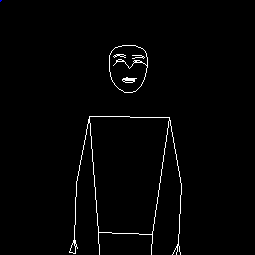

In [16]:
#make Black background

height = 255
width = 255
for i in range(1):
  img = np.zeros((height, width, 3), dtype=np.uint8)
  matrix = out[i]
  face = matrix[:468]
  pose = matrix[468: 501]
  lh = matrix[501: 522]
  rh = matrix[522: ]
  display_landmarks(img, face, pose, lh, rh)
  cv2_imshow(img)


## Make Video

In [17]:
out.shape

(60, 543, 3)

In [18]:
# importing libraries
import os
import cv2
from PIL import Image


# Video Generating function
def generate_video(out, video_name, height, width):
  fps = 30
  fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec pour MP4
  video = cv2.VideoWriter(video_name, fourcc, fps, (width, height))
  height, width, layers = (height, width, 3)


	#for image in out:
  for i in range(60):
    img = np.zeros((height, width, 3), dtype=np.uint8)
    matrix = out[i]
    face = matrix[:468]
    pose = matrix[468: 501]
    lh = matrix[501: 522]
    rh = matrix[522: ]
    display_landmarks(img, face, pose, lh, rh)
    #cv2_imshow(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    video.write(img)
  # Deallocating memories taken for window creation
  cv2.destroyAllWindows()
  video.release() # releasing the video generated


# Calling the generate_video function
#generate_video(out, video_name, height, width)


# Generate Video with Landmarks

In [ ]:
#test
mp_holistic = mp.solutions.holistic
holistic=mp_holistic.Holistic(min_detection_confidence=0.3, min_tracking_confidence=0.5)
video_path = "video_data/val/computer/12335.mp4"
video_landmarks = process_video(video_path)
print(video_landmarks.shape)
generate_video(video_landmarks, "computer_landmarks.mp4", 480, 640)



Frames per second (FPS): 25.0
Total number of frames: 64
No more frames or error occurred.
(60, 543, 3)


In [ ]:
!ls

 3d_landmarks_bgr.png							       video.mp4
 3d_landmarks.png							       WLASL_v0.3.json
 computer_landmarks.avi							       word_classes.txt
 computer_landmarks.mp4							       X_test.npy
'Mediapipe_data Extract.ipynb'						       X_test_video.npy
 mygeneratedvideo.avi							       X_train.npy
 sign_cnn_lstm_model.h5							       X_train_video.npy
'Sign Lang Machine Translation With Visual Transformers(TimeSformer) .ipynb'   X_val.npy
'SignLang with CNN- LSTM.ipynb'						       X_val_video.npy
 video0.avi								       y_test.npy
 video1.avi								       y_test_video.npy
 video2.avi								       y_train.npy
 video2.mp4								       y_train_video.npy
 video3.avi								       y_val.npy
 video_data								       y_val_video.npy


# Make Landmarks dataset


* For each video, we have a matrix of (60, 543, 3); we will create a dataset divided into train, test, and validation sets.

* Each data slice (train, test, val) contains folders named after the labels.

* We will save these data into folders in .npy format, which will be used later by the models.

## Create folders and moove videos

In [ ]:
!ls

 3d_landmarks_bgr.png							       WLASL_v0.3.json
 3d_landmarks.png							       word_classes.txt
'Mediapipe_data Extract.ipynb'						       X_test.npy
 mygeneratedvideo.avi							       X_test_video.npy
 sign_cnn_lstm_model.h5							       X_train.npy
'Sign Lang Machine Translation With Visual Transformers(TimeSformer) .ipynb'   X_train_video.npy
'SignLang with CNN- LSTM.ipynb'						       X_val.npy
 video0.avi								       X_val_video.npy
 video1.avi								       y_test.npy
 video2.avi								       y_test_video.npy
 video2.mp4								       y_train.npy
 video3.avi								       y_train_video.npy
 video_data								       y_val.npy
 video.mp4								       y_val_video.npy


In [ ]:
with open(os.path.join(workdir, "word_classes.txt")) as f:
  liste = f.readlines()
liste = [i.split("\t")[-1].split("\n")[0] for i in liste]
liste = [i for i in liste if i!= '']
print(f"We have {len(liste)} differents words")

We have 2000 differents words


In [ ]:
# We'll use just the 5 st words for test purposes
classes_list = liste[:5]

In [ ]:
with open("WLASL_v0.3.json", "r") as f:
  json_data = json.load(f)
print(json_data[0:1])

[{'gloss': 'book', 'instances': [{'bbox': [385, 37, 885, 720], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 0, 'signer_id': 118, 'source': 'aslbrick', 'split': 'train', 'url': 'http://aslbricks.org/New/ASL-Videos/book.mp4', 'variation_id': 0, 'video_id': '69241'}, {'bbox': [190, 25, 489, 370], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 1, 'signer_id': 90, 'source': 'aslsignbank', 'split': 'train', 'url': 'https://aslsignbank.haskins.yale.edu/dictionary/protected_media/glossvideo/ASL/BO/BOOK-418.mp4', 'variation_id': 0, 'video_id': '65225'}, {'bbox': [262, 1, 652, 480], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 2, 'signer_id': 110, 'source': 'valencia-asl', 'split': 'train', 'url': 'https://www.youtube.com/watch?v=0UsjUE-TXns', 'variation_id': 0, 'video_id': '68011'}, {'bbox': [123, 19, 516, 358], 'fps': 25, 'frame_end': 60, 'frame_start': 1, 'instance_id': 3, 'signer_id': 113, 'source': 'lillybauer', 'split': 'train', 'url': 'https:/

In [ ]:
#Define directories
sign_video_data_dir ="video_data"
train_dir =os.path.join(sign_video_data_dir, "train")
val_dir =os.path.join(sign_video_data_dir, "val")
test_dir = os.path.join(sign_video_data_dir, "test")

if not os.path.exists(sign_video_data_dir):
  os.mkdir(sign_video_data_dir)
  os.mkdir(train_dir)
  os.mkdir(val_dir)
  os.mkdir(test_dir)

In [ ]:
!cd video_data/ && ls

test  train  val


In [ ]:
for data in json_data[:10]:
  for instances in data["instances"]:
    #print(instances['split'], instances['url'], data['gloss'])# instances['video_id'] )#['fps'])
    #print(path)
    path = os.path.join(sign_video_data_dir, f"{instances['split']}/{data['gloss']}")
    print(instances)
    break

  break

{'bbox': [385, 37, 885, 720], 'fps': 25, 'frame_end': -1, 'frame_start': 1, 'instance_id': 0, 'signer_id': 118, 'source': 'aslbrick', 'split': 'train', 'url': 'http://aslbricks.org/New/ASL-Videos/book.mp4', 'variation_id': 0, 'video_id': '69241'}


In [18]:
# Split Video
import shutil
for data in json_data:
  for instances in data["instances"]:
    #print(instances['split'], instances['url'], data['gloss'])# instances['video_id'] )#['fps'])
    path = os.path.join(sign_video_data_dir, f"{instances['split']}/{data['gloss']}")
    video_path = f"/content/drive/MyDrive/Tensorflow dev/real_time_sign_language/wasl_data/wlasl-complete/videos/{instances['video_id']}.mp4"
    try:
      shutil.move(video_path, os.path.join(path, f"{instances['video_id']}.mp4"))
    except:
      pass
      #print(video_path, os.path.join(path, f"{instances['video_id']}.mp4"))
